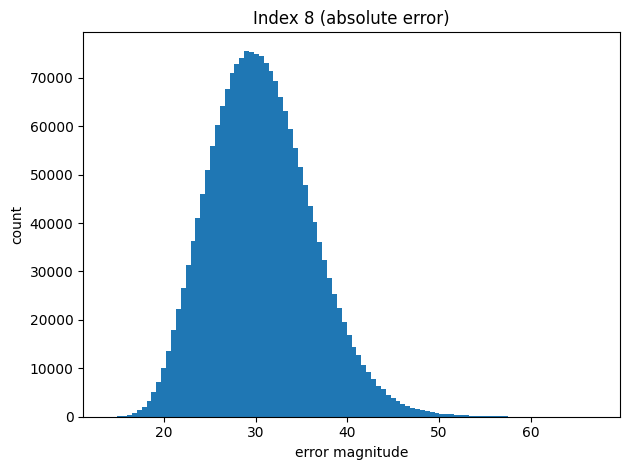

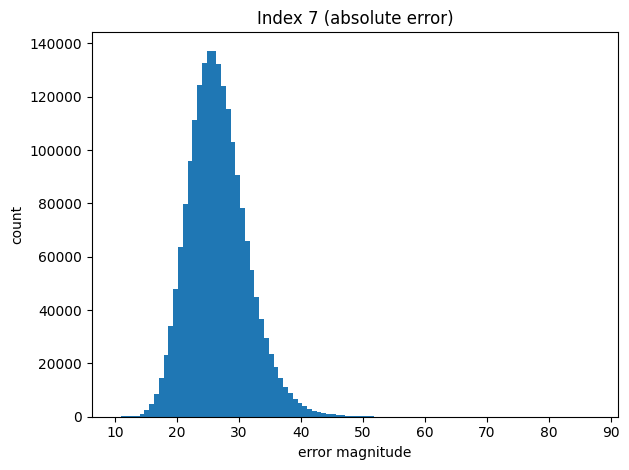

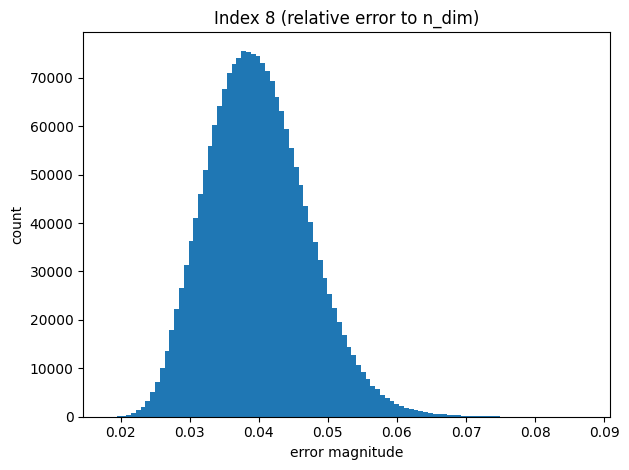

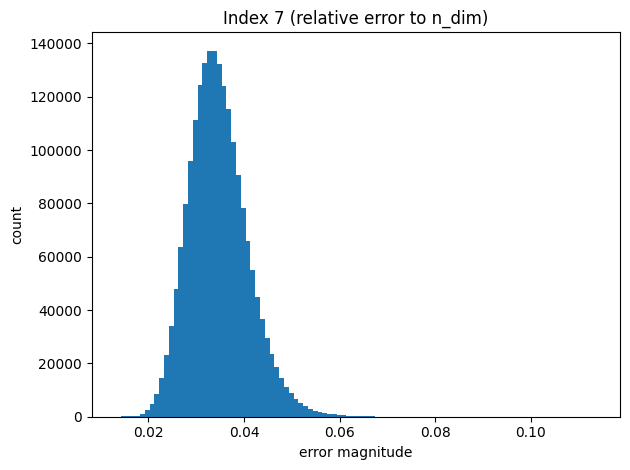

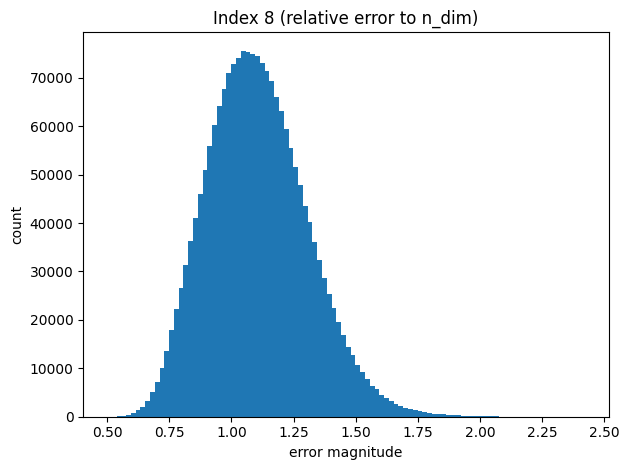

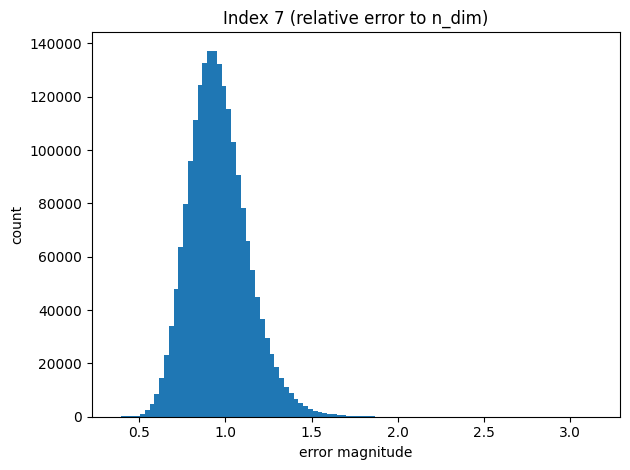

In [1]:
from pathlib import Path
import math
import numpy as np, matplotlib.pyplot as plt

data_dir1 = Path("runs/gpt2_L8_ln2_7c1b91f2_transcoder_err8")
data_dir2 = Path("runs/gpt2_L8_ln2_7c1b91f2_transcoder_err7")

def plot_data(data_dir: Path, title: str, normalizer: float = 1.0):
    errors = [np.load(f) for f in sorted(data_dir.glob("*.npy"))]
    assert all(e.ndim == 1 for e in errors)
    all_err = np.concatenate(errors) / normalizer
    plt.hist(all_err, bins=100)
    plt.xlabel("error magnitude")
    plt.ylabel("count")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_data(data_dir1, title="Index 8 (absolute error)")
plot_data(data_dir2, title="Index 7 (absolute error)")
plot_data(data_dir1, title="Index 8 (relative error to n_dim)", normalizer=768)
plot_data(data_dir2, title="Index 7 (relative error to n_dim)", normalizer=768)
plot_data(data_dir1, title="Index 8 (relative error to n_dim)", normalizer=math.sqrt(768))
plot_data(data_dir2, title="Index 7 (relative error to n_dim)", normalizer=math.sqrt(768))

Loading PCA data: 100%|██████████| 18/18 [00:00<00:00, 248.39it/s]


Finding min/max values...


Building histogram: 100%|██████████| 18/18 [00:00<00:00, 28.68it/s]


Normalizing total_samples=2000000
Creating 2D histogram...


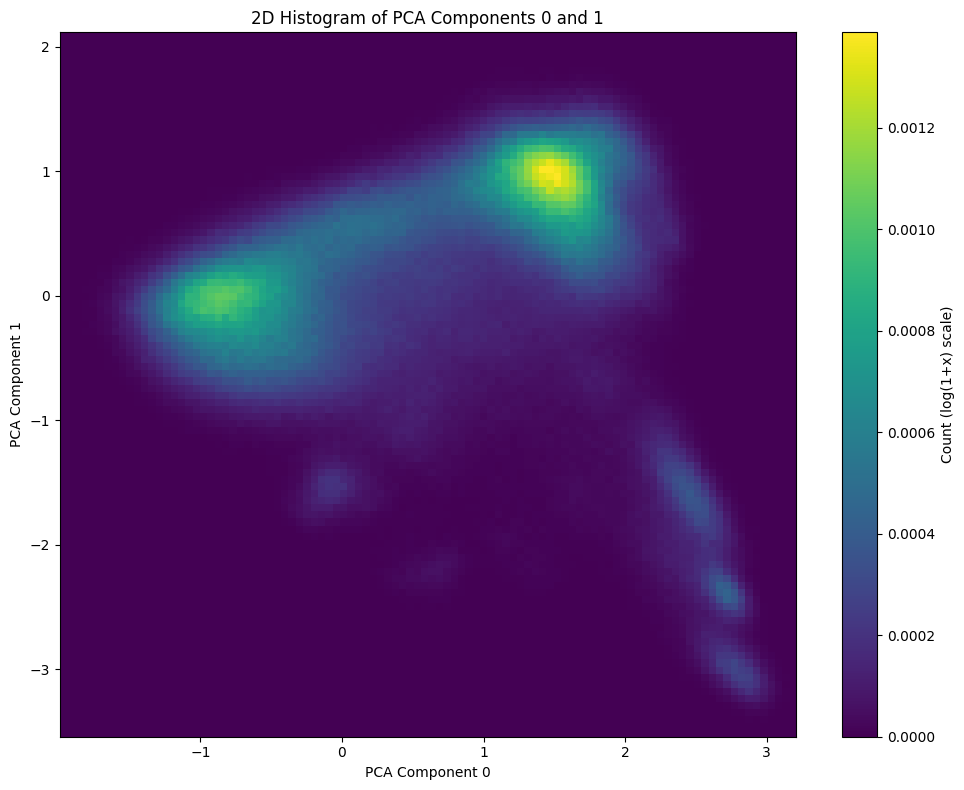

Loaded 18 files with total 2000000.0 samples
PCA component 1 range: [-1.99, 3.21]
PCA component 2 range: [-3.54, 2.12]


Loading PCA data: 100%|██████████| 18/18 [00:00<00:00, 865.96it/s]


Finding min/max values...


Building histogram: 100%|██████████| 18/18 [00:00<00:00, 29.38it/s]


Normalizing total_samples=2000000
Creating 2D histogram...


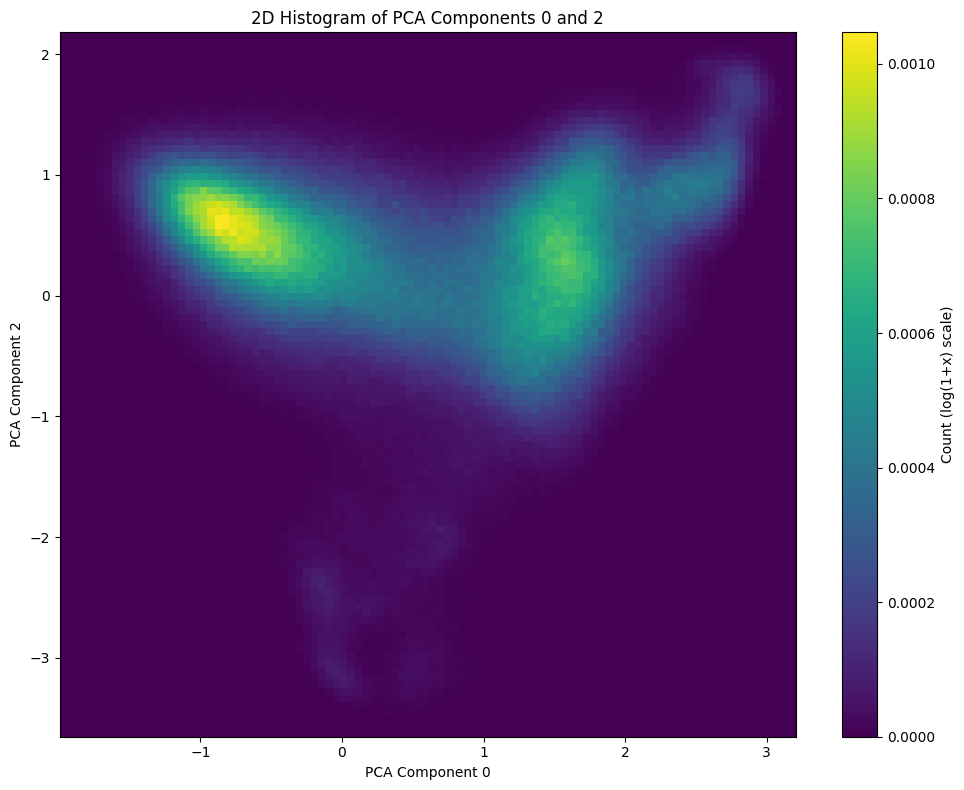

Loaded 18 files with total 2000000.0 samples
PCA component 1 range: [-1.99, 3.21]
PCA component 2 range: [-3.65, 2.18]


Loading PCA data: 100%|██████████| 18/18 [00:00<00:00, 658.92it/s]


Finding min/max values...


Building histogram: 100%|██████████| 18/18 [00:00<00:00, 28.88it/s]


Normalizing total_samples=2000000
Creating 2D histogram...


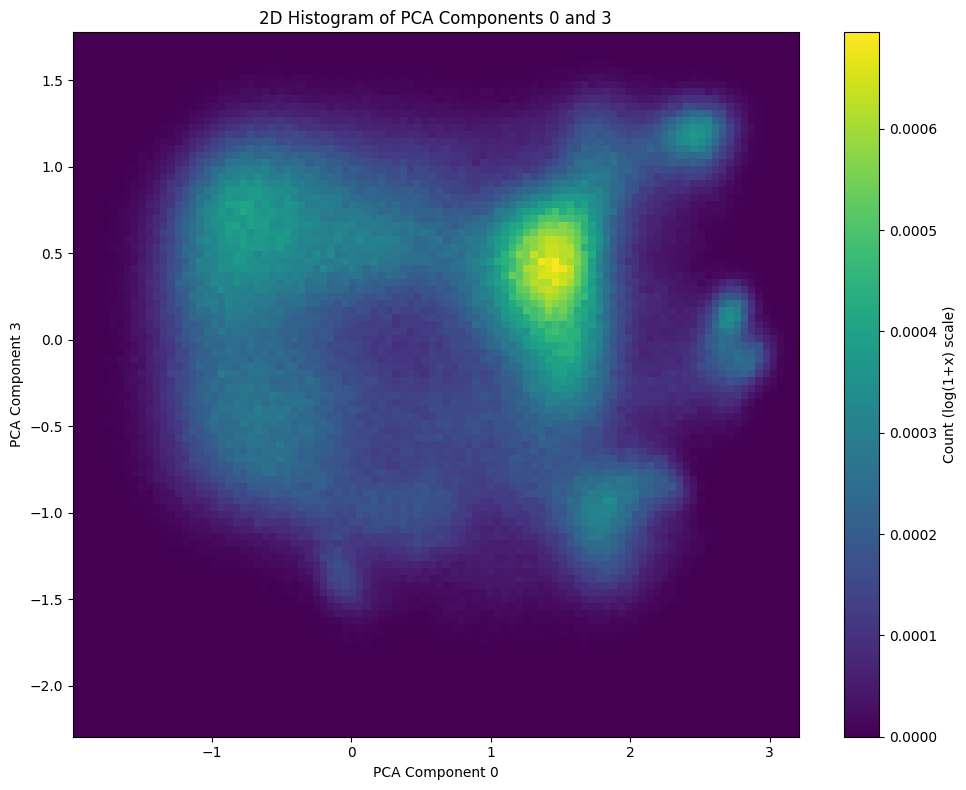

Loaded 18 files with total 2000000.0 samples
PCA component 1 range: [-1.99, 3.21]
PCA component 2 range: [-2.30, 1.78]


In [5]:
import tqdm
from pathlib import Path
import itertools
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, List

"""
TODO(Adriano) something is wrong here since we do not match with Ionel's results (there is no circle?)
"""

# Load PCA data
def plot_pca_of_components(pca_dir: Path, i: int, j: int, value_tensors: Optional[List[np.ndarray]] = None):
    pca_files = sorted(pca_dir.glob("*.npy"))

    # Load and concatenate all PCA data
    pca_data = []
    for f in tqdm.tqdm(pca_files, desc="Loading PCA data"):
        data = np.load(f)
        # Assert that data is batch x 10
        assert data.ndim == 2 and data.shape[1] == 10, f"Expected shape (batch, 10), got {data.shape}"
        pca_data.append(data)

    # Find min and max values for the first two PCA components
    min_i, max_i = float('inf'), float('-inf')
    min_j, max_j = float('inf'), float('-inf')
    total_samples = 0
    assert min_i > -10 and max_i < 10, f"min_i={min_i} > -10 or max_i={max_i} < 10"
    assert min_j > -10 and max_j < 10, f"min_j={min_j} > -10 or max_j={max_j} < 10"

    print("Finding min/max values...")
    for data in tqdm.tqdm(pca_data, desc="Finding min/max values"):
        min_i = min(min_i, data[:, i].min())
        max_i = max(max_i, data[:, i].max())
        min_j = min(min_j, data[:, j].min())
        max_j = max(max_j, data[:, j].max())
        total_samples += data.shape[0]

    # Create histogram bins
    num_bins = 100
    hist_2d = np.zeros((num_bins, num_bins), dtype=np.int64)
    f_hist_2d = np.zeros((num_bins, num_bins), dtype=np.float64) if value_tensors is not None else None
    bin_width_i = (max_i - min_i) / num_bins
    bin_width_j = (max_j - min_j) / num_bins

    for data_idx, data in enumerate(tqdm.tqdm(pca_data, desc="Building histogram")):
        # Convert data points to bin indices
        bin_indices_i = np.clip(((data[:, i] - min_i) / bin_width_i).astype(np.int64), 0, num_bins - 1)
        bin_indices_j = np.clip(((data[:, j] - min_j) / bin_width_j).astype(np.int64), 0, num_bins - 1)
        value_tensor = None
        if value_tensors is not None:
            value_tensor = value_tensors[data_idx]
            assert value_tensor.ndim == 1 and value_tensor.shape[0] == data.shape[0]
            assert bin_indices_i.shape == bin_indices_j.shape == value_tensor.shape
        for idx_i, idx_j in zip(bin_indices_i, bin_indices_j):
            hist_2d[idx_j, idx_i] += 1  # Note: j is y-axis (rows), i is x-axis (columns)
            if value_tensors is not None:
                f_hist_2d[idx_j, idx_i] += value_tensor[data_idx]
            

    assert value_tensors is not None or hist_2d.sum() == total_samples, f"hist_2d.sum()={hist_2d.sum()} != total_samples={total_samples}"
    assert total_samples > 0, f"total_samples={total_samples} <= 0"
    print(f"Normalizing total_samples={total_samples}")
    total_samples = float(total_samples)  # Convert to double
    hist_2d = hist_2d.astype(np.float64)  # Cast to float64 (double precision)
    if f_hist_2d is not None:
        f_hist_2d = f_hist_2d.astype(np.float64)
        # f_hist_2d[hist_2d > 0] /= hist_2d[hist_2d > 0]
    hist_2d /= total_samples

    # Plot the histogram
    print("Creating 2D histogram...")
    plt.figure(figsize=(10, 8))
    # Use log scale for better visualization
    hist_2d_log = np.log1p(hist_2d)  # log(1+x) to handle zeros
    plt.imshow(hist_2d_log, origin='lower', aspect='auto', cmap='viridis',
            extent=[min_i, max_i, min_j, max_j])
    plt.colorbar(label='Count (log(1+x) scale)')
    plt.xlabel(f'PCA Component {i}')
    plt.ylabel(f'PCA Component {j}')
    plt.title(f'2D Histogram of PCA Components {i} and {j}')
    plt.tight_layout()
    plt.show()

    if f_hist_2d is not None:
        print("Creating 2D histogram with values...")
        plt.figure(figsize=(10, 8))
        plt.imshow(f_hist_2d, origin='lower', aspect='auto', cmap='viridis',
                extent=[min_i, max_i, min_j, max_j])
        plt.colorbar(label='Value')
        plt.xlabel(f'PCA Component {i}')
        plt.ylabel(f'PCA Component {j}')
        plt.title(f'2D Function Value Map of PCA Components {i} and {j}')
        plt.tight_layout()
        plt.show()

    # Print some statistics
    print(f"Loaded {len(pca_files)} files with total {total_samples} samples")
    print(f"PCA component 1 range: [{min_i:.2f}, {max_i:.2f}]")
    print(f"PCA component 2 range: [{min_j:.2f}, {max_j:.2f}]")

pca_dir = Path("runs/gpt2_L8_ln2_7c1b91f2_pca10")
for i, j in list(itertools.combinations(range(10), 2))[:3]:
    plot_pca_of_components(pca_dir, i, j)

Found 19 value tensors


Loading PCA data: 100%|██████████| 18/18 [00:00<00:00, 319.12it/s]


Finding min/max values...


Building histogram:   0%|          | 0/18 [00:00<?, ?it/s]

Building histogram: 100%|██████████| 18/18 [00:01<00:00, 13.10it/s]


Normalizing total_samples=2000000
Creating 2D histogram...


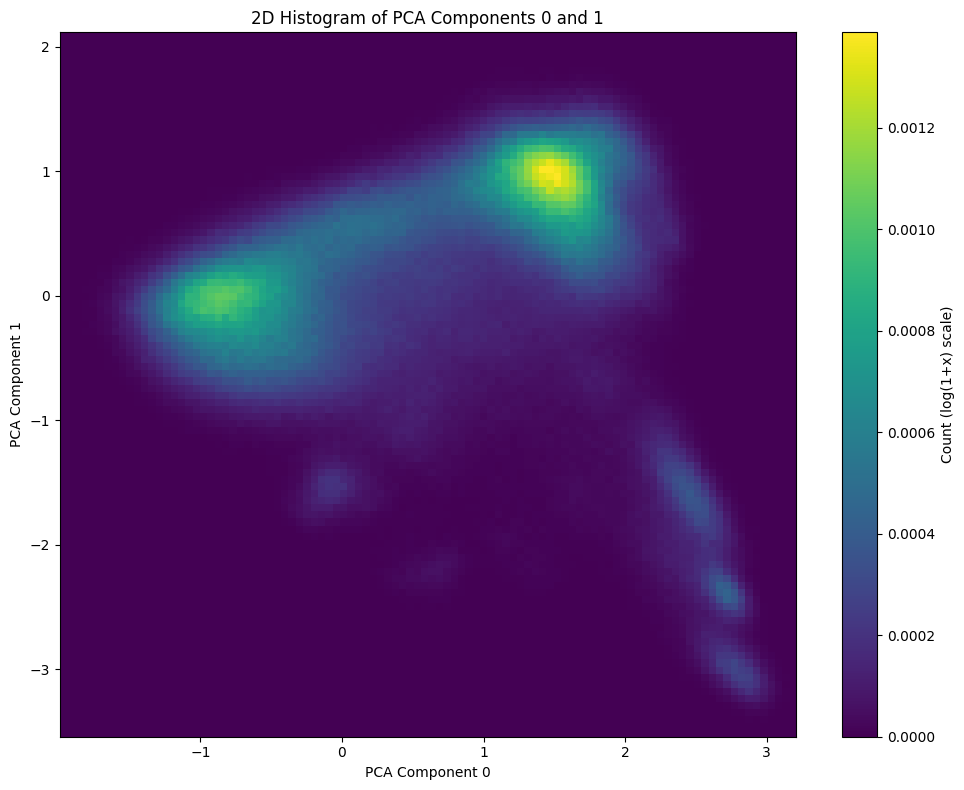

Creating 2D histogram with values...


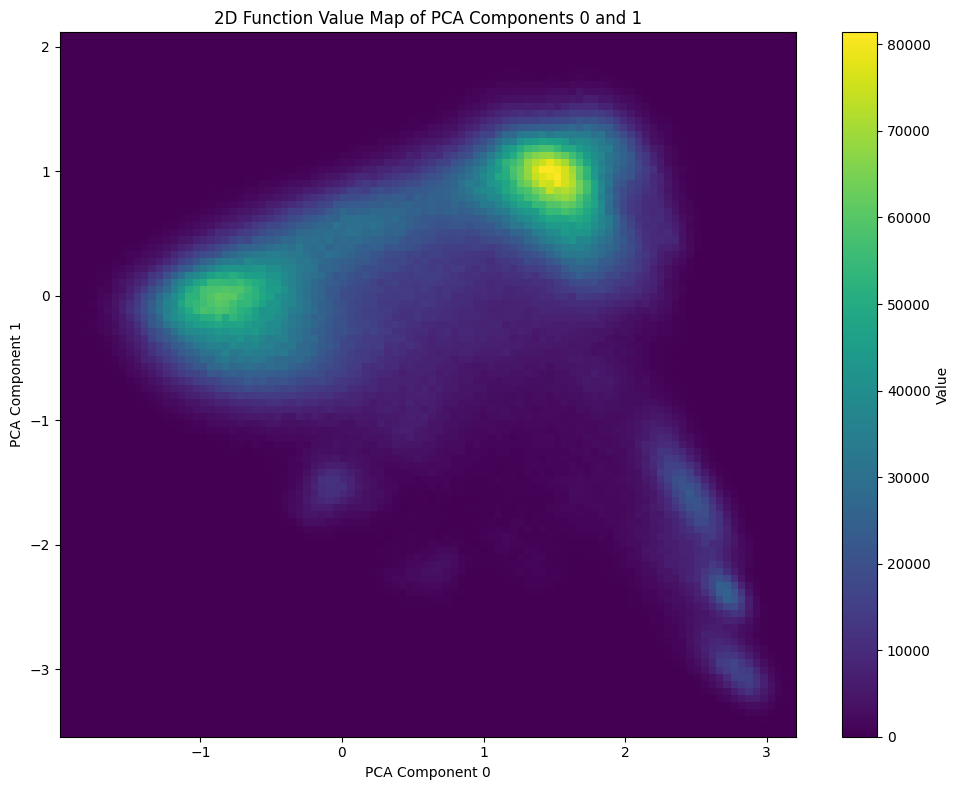

Loaded 18 files with total 2000000.0 samples
PCA component 1 range: [-1.99, 3.21]
PCA component 2 range: [-3.54, 2.12]


Loading PCA data: 100%|██████████| 18/18 [00:00<00:00, 694.83it/s]


Finding min/max values...


Building histogram: 100%|██████████| 18/18 [00:01<00:00, 13.17it/s]


Normalizing total_samples=2000000
Creating 2D histogram...


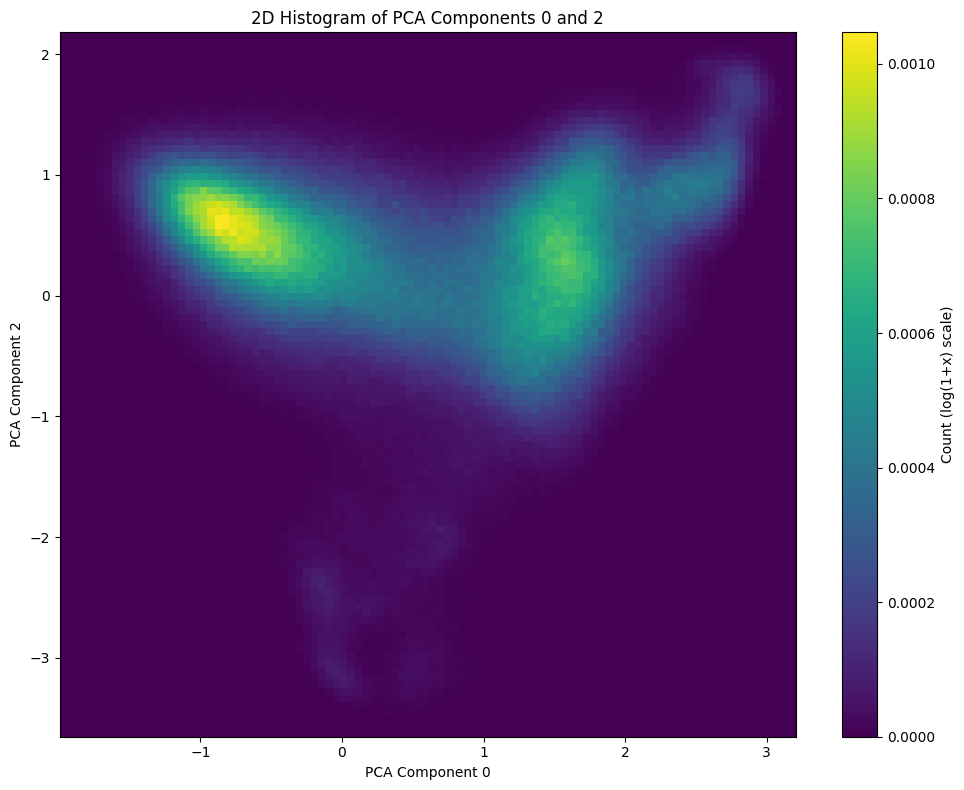

Creating 2D histogram with values...


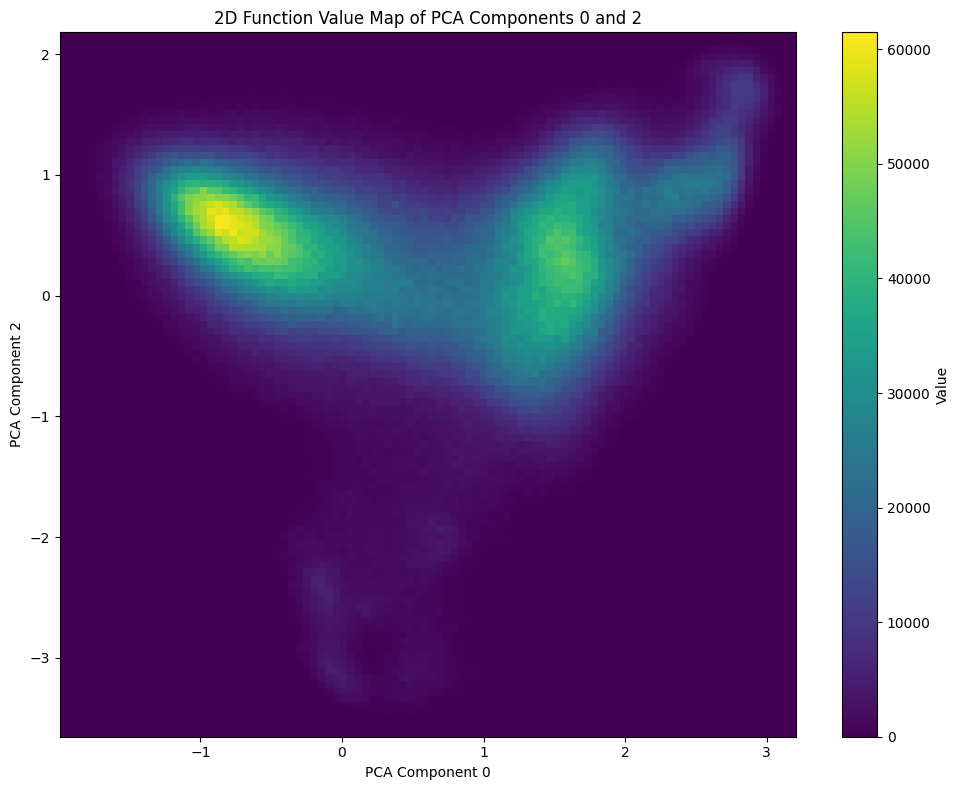

Loaded 18 files with total 2000000.0 samples
PCA component 1 range: [-1.99, 3.21]
PCA component 2 range: [-3.65, 2.18]


Loading PCA data: 100%|██████████| 18/18 [00:00<00:00, 643.90it/s]


Finding min/max values...


Building histogram: 100%|██████████| 18/18 [00:01<00:00, 12.96it/s]


Normalizing total_samples=2000000
Creating 2D histogram...


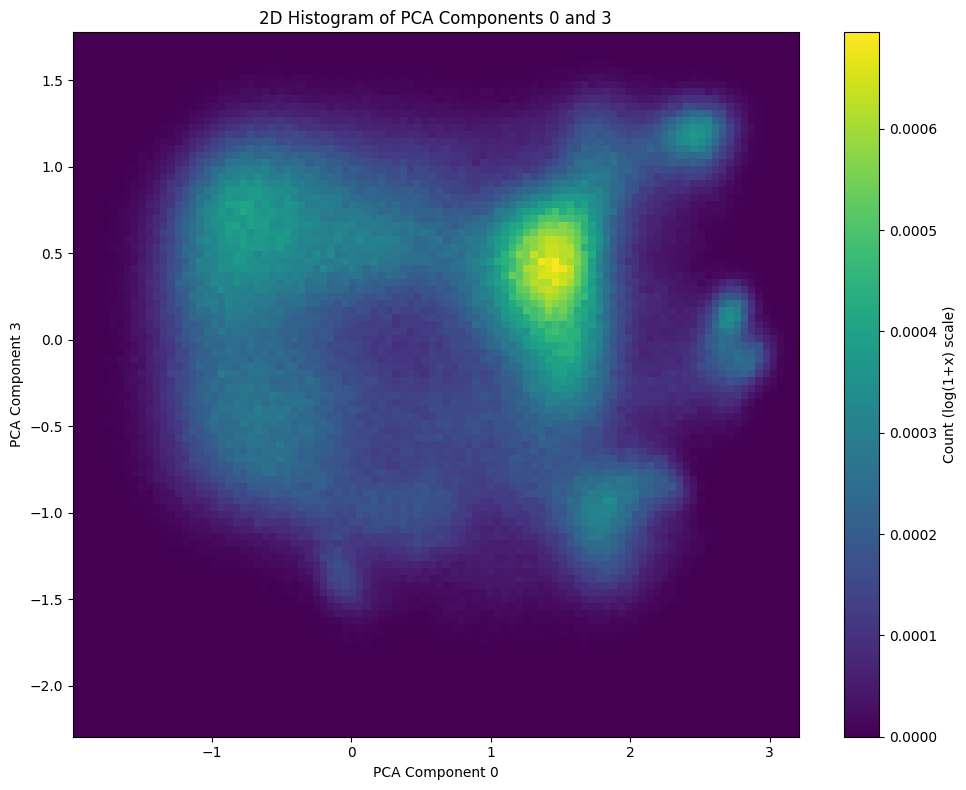

Creating 2D histogram with values...


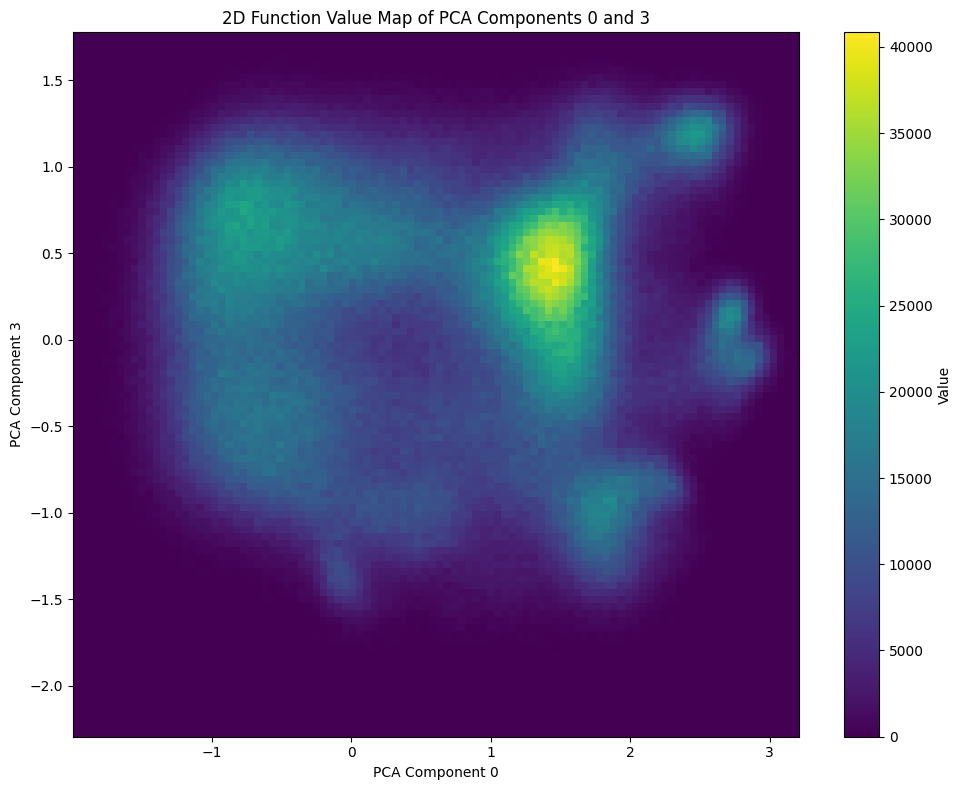

Loaded 18 files with total 2000000.0 samples
PCA component 1 range: [-1.99, 3.21]
PCA component 2 range: [-2.30, 1.78]


In [6]:
error_dir = Path("runs/gpt2_L8_ln2_7c1b91f2_transcoder_err7")
value_tensors = [np.load(f) for f in sorted(error_dir.glob("*.npy"))]
print(f"Found {len(value_tensors)} value tensors")
print("="*100)
for i, j in list(itertools.combinations(range(10), 2))[:3]:
    plot_pca_of_components(pca_dir, i, j, value_tensors)
